<h3> Project: Benchmarking of GTM and other machine learning methods on prediction of aqueous solubility of organic compounds </h3>

<h4>Summary</h4>
A performance comparison of GTM and kGTM against several well-established machine learning methods is made, with the main goal being prediction of aqueous solubiity of organic compounds. A curated datasset of 9982 compounds was taken from kaggle (<a href="https://www.kaggle.com/sorkun/aqsoldb-a-curated-aqueous-solubility-dataset" target="_blank">https://www.kaggle.com/sorkun/aqsoldb-a-curated-aqueous-solubility-dataset</a>). The dataset was striped of salts and compounds with multiple occurences. The RDkit module was Chem was used to calculate 2D autocorrelation descriptors based on <u>topological properties</u> (to be checked). A set of two machine learning models was built for each method, one based on the descriptors provided in the original dataset, and another based on the autocorrelation descriptors.

<h4>To do list</h4>
<ul>
    <li>prepare the training and test set using "original" descriptors</li>
    <li>prepare the training and test set using RDkit AUTOCORR2D descriptors</li>
    <li>build the GTM and kGTM machine learning models</li>
    <li>build other machine learning models:</li>
    <ul>
        <li>elastic net regression</li>
        <li>suppoort vector machine with rbf kernel</li>
        <li>k-NN</li>
        <li>random forest</li>
        <li>naive bayes</li>
    </ul>
    <li style="color:red">Use GridSearchCV to find the best parameters for each model!!!</li>
</ul>



### Step 1: Data Prepocessing

In [6]:
# Some python imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Importing the dataset
data = pd.read_csv("solubility.csv")

In [8]:
# Extracting all the descriptors

# Original descriptors
X1 = data[['MolWt', 'MolLogP',
       'MolMR', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors',
       'NumHeteroatoms', 'NumRotatableBonds', 'NumValenceElectrons',
       'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings',
       'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT']].copy()

#Autocorrelation descriptors
X2 = data["AutoCorrVector"].copy()

# Dependent property
y1 = data["Solubility"].copy()
y2 = data["Solubility"].copy()

In [9]:
# Converting the autocorrelation descriptors into a machine-readable format

def str2list(x):
    return x.strip('][').split(', ')

X2 = pd.DataFrame(X2)
X2["AutoCorrList"] = X2["AutoCorrVector"].apply(str2list)
X2.drop("AutoCorrVector",axis=1,inplace=True)
X2 = pd.DataFrame(data=np.array([i for i in X2["AutoCorrList"]]))

# Converting all the columns to float64 format
for col in X2.columns:
    X2[col]=X2[col].astype(float)

In [10]:
# Some cells from AUTOCORR2D descriptor blocks (X2) have undefined values
# we'll have to drop them
# Dropping the NaN values in X2 block
X2.dropna(axis=0,inplace=True)
# Dropping the corresponding rows in the y ... 'Solubility' block
listdrop = [i for i in y2.index if i not in X2.index]
y1.drop(listdrop,axis=0,inplace=True)
y2.drop(listdrop,axis=0,inplace=True)
X1.drop(listdrop,axis=0,inplace=True)

In [18]:
# Importing the sklearn preprocessing tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV

In [12]:
# Now the data is ready for machine learning!!!

#### Model 1: ugtm eGTR (generative topogaphic mapping regressor)

In [13]:
# X1 train-test-split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [14]:
# Normalizing the data
S1 = StandardScaler()
S2 = StandardScaler()
X1_train = S1.fit_transform(X1_train)
X1_test = S1.transform(X1_test)
X2_train = S2.fit_transform(X2_train)
X2_test = S2.transform(X2_test)

In [19]:
# Predicting the Solubility using gtm
from ugtm import eGTM,eGTR,runGTM,runkGTM

In [20]:
# Defining some grid search parameters
tuned_params = {'regul': [0.0001, 0.001, 0.01, 0.1, 1], # L2 regularization coefficient
        's': [0.1, 0.2, 0.3], # Width of the RBF center
        'k': [25], # sqrt of the number of GTM nodes
        'm': [5]} # sqrt of the number of RBF centers

In [21]:
gtr1 = GridSearchCV(estimator=eGTR(),param_grid=tuned_params,cv=3,scoring="neg_mean_squared_error")
gtr2 = GridSearchCV(estimator=eGTR(),param_grid=tuned_params,cv=3,scoring="neg_mean_squared_error")

In [23]:
gtr1.fit(X1_train,y1_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=eGTR(k=16, m=4, n_neighbors=2, niter=200,
                            random_state=1234, regul=0.1,
                            representation='modes', s=0.3, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'k': [25], 'm': [5],
                         'regul': [0.0001, 0.001, 0.01, 0.1, 1],
                         's': [0.1, 0.2, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [24]:
print(gtr1.best_params_)

{'k': 25, 'm': 5, 'regul': 0.01, 's': 0.1}


In [25]:
gtr2.fit(X2_train,y2_train)

KeyboardInterrupt: 

In [38]:
# Predicting the labels
y2_pred = gtr2.predict(X2_test)

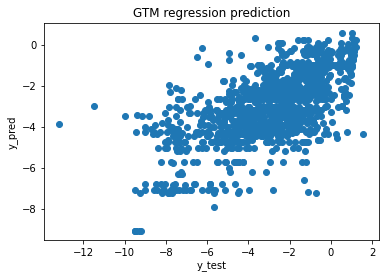

In [41]:
plt.title("GTM regression prediction")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.scatter(y2_test,y2_pred)

In [44]:
gtm = runGTM(X1)

In [45]:
from ugtm import plot_html

In [ ]:
gtm.plot_html()

In [42]:
from sklearn.metrics import r2_score

In [43]:
# Goodness of prediction
uGTMr2 = r2_score(y2_test,y2_pred)
print(uGTMr2)

0.3967754741780041


In [17]:
# Goodness of fit
y_train_pred = gtr.predict(X_train)
print(r2_score(y_train,y_train_pred))

0.6473408736032291


In [52]:
# Getting the GTM transform for the X_train and X_test

In [65]:
egtm = eGTM()
X_train_proj = egtm.fit(X_train)
X_all_proj = egtm.transform(X)

In [72]:
projected_data = pd.DataFrame(X_all_proj,columns=["X1","X2"])

In [92]:
print(data.iloc[147]["SMILES"])
print(data.iloc[147]["Name"])
print(data.iloc[147]["Solubility"])

OCC(O)C(O)C(O)CO
D-erythro-pentitol
0.6252744890999999


In [93]:
print(data.iloc[4035]["SMILES"])
print(data.iloc[4035]["Name"])
print(data.iloc[4035]["Solubility"])

OC(=O)c1ccccc1C2OC(=O)c3ccccc23
benzoic acid, o-phthalidyl-
-3.1042


In [19]:
# GTM "activity" landscape

In [38]:
grid = pd.DataFrame(gtr.optimizedModel.matX,columns=["X1","X2"])

In [39]:
grid["logS"] = gtr.node_label 

In [51]:
trace = [go.Heatmap(x=grid['X1'],y=grid['X2'],z=grid['logS'],colorscale='RdYlBu_r',colorbar=dict(title="logS"))]

layout = go.Layout(title='GTM Activity landscape',xaxis_title="X1",yaxis_title="X2",width=600,height=600)

fig = go.Figure(data=trace,layout=layout)

fig.show()

In [18]:
# Let's test some other models
# Multilinear regression
# Lasso regression
# Ridge regression
# SVM Regression
# Random Forest Regression
# KNNeighbors regression

In [45]:
# Multilinear regression
from sklearn.linear_model import LinearRegression,Lasso,Ridge

In [39]:
Lreg = LinearRegression()
Lreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
y_pred = Lreg.predict(X_test)

In [41]:
print(r2_score(y_test,y_pred))

0.557269642064081


In [71]:
# Temporarily inverting the transformations on the training and test sets
X_train = stdsc.inverse_transform(X_train)
X_test = stdsc.inverse_transform(X_test)

In [82]:
# Ridge regression
Ridge_alpha = list(range(100,1000,50))
r2_scores = []
for a in Ridge_alpha:
    R = Ridge(alpha=a)
    R.fit(X_train,y_train)
    y_pred = R.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    r2_scores.append(r2)

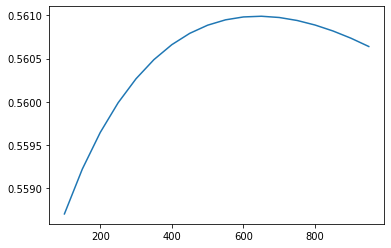

In [83]:
plt.plot(Ridge_alpha,r2_scores)

In [93]:
Lasso_alpha = [0.5,0.75,1,1.25,1.5]
r2_scores = []
for a in Lasso_alpha:
    L = Lasso(alpha=a)
    L.fit(X_train,y_train)
    y_pred = L.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    r2_scores.append(r2)

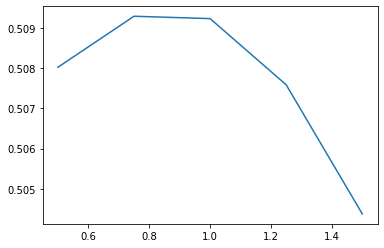

In [94]:
plt.plot(Lasso_alpha,r2_scores)

In [95]:
# SVM Regression
from sklearn.svm import SVR

In [96]:
# Transforming back to the normalized dataset
X_train = stdsc.transform(X_train)
X_test = stdsc.transform(X_test)

In [98]:
listC = [1,10,100,1000]
r2_scores = []
for c in listC:
    svr = SVR(kernel="rbf",C=c)
    svr.fit(X_train,y_train)
    y_pred = svr.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    r2_scores.append(r2)

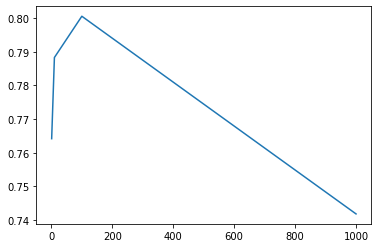

In [99]:
plt.plot(listC,r2_scores)

In [12]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

In [13]:
rfr = RandomForestRegressor(n_estimators=500)

In [14]:
# Inverting the transforms
X_train = stdsc.inverse_transform(X_train)
X_test = stdsc.inverse_transform(X_test)

In [15]:
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [17]:
y_pred = rfr.predict(X_test)

In [19]:
print(r2_score(y_test,y_pred))

0.7893448340455618


In [20]:
# KNN regression
from sklearn.neighbors import KNeighborsRegressor

In [23]:
listKNN = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30]
r2_scores = []
for NN in listKNN:
    KNN = KNeighborsRegressor(n_neighbors=NN,weights="distance")
    KNN.fit(X_train,y_train)
    y_pred = KNN.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    r2_scores.append(r2)

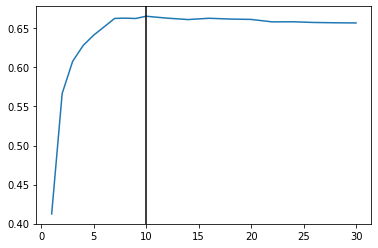

In [37]:
plt.plot(listKNN,r2_scores)
plt.axvline(listKNN[np.array(r2_scores).argmax()],color="k")

In [33]:
# Now let's print all results together
solubility_report = 

10